In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from scipy import optimize
import inspect
import h5py

In [2]:
%matplotlib notebook

In [3]:
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile


from discharge_tools import *

In [4]:
def extract_fft_peaks(data,axis,fsamp = 0, harm_freq = 0):
    freq,psd = data.psd2(axis)
    fft = np.sqrt(psd)
    
    unfiltered_peaks = signal.find_peaks(np.log(fft))[0]
    harmonics_0 = [peak for peak in unfiltered_peaks if freq[peak]%harm_freq == 0]
    harmonics_index = np.asarray([harm for harm in harmonics_0 if harmonics_0.index(harm)<50 ])
    
    return freq[harmonics_index],fft[harmonics_index]

In [5]:
fname_x = r'/data/new_trap/20190708/Bead2/TransFunc/TransFuncX_14.h5'
bd_x= BeadDataFile.BeadDataFile(fname_x)
fname_y = r'/data/new_trap/20190708/Bead2/TransFunc/TransFuncY_16.h5'
bd_y = BeadDataFile.BeadDataFile(fname_y)
Xfreq_x,Xfft_x = extract_fft_peaks(bd_x,'x',fsamp = bd_x.fsamp, harm_freq = 23)
Xfreq_y,Xfft_y = extract_fft_peaks(bd_x,'y',fsamp = bd_x.fsamp, harm_freq = 23)
Yfreq_y,Yfft_y = extract_fft_peaks(bd_y,'y',fsamp = bd_y.fsamp, harm_freq = 23)
Yfreq_x,Yfft_x = extract_fft_peaks(bd_y,'x',fsamp = bd_y.fsamp, harm_freq = 23)

In [17]:
in_dict = {'fxx': Xfreq_x, 'fyy': Yfreq_y, 'fxy': Xfreq_y, 'fyx': Yfreq_x}
out_dict = {'Oxx': Xfft_x, 'Oyy': Yfft_y, 'Oxy': Xfft_y, 'Oyx': Yfft_x}

In [208]:
def Xmodel_x(params,fxx):
    Axx,Ayy,Axy,Ayx,Kxx,Kyy,Kxy,Lxx,Lyy,Lxy = params
    numerator = Axx*np.sqrt((Kyy-(2*np.pi*fxx)**2)**2 + (Lyy**2)*(2*np.pi*fxx)**2)
    denominator = np.sqrt(((2*np.pi*fxx)**4 + (Lxy**2-Lxx*Lyy-Kxx-Kyy)*(2*np.pi*fxx)**2 + (Kxx*Kyy - Kxy**2))**2 + ((-Lxx-Lyy)*(2*np.pi*fxx)**3 + (Kxx*Lyy + Kyy*Lxx - 2*Kxy*Lxy)*(2*np.pi*fxx))**2)
    return numerator/denominator

In [209]:
def Xmodel_y(params,fxy):
    Axx,Ayy,Axy,Ayx,Kxx,Kyy,Kxy,Lxx,Lyy,Lxy = params
    numerator = Axy*np.sqrt(Kxy**2+(Lxy**2)*(2*np.pi*fxy)**2)
    denominator = np.sqrt(((2*np.pi*fxy)**4+(Lxy**2-Lxx*Lyy-Kxx-Kyy)*(2*np.pi*fxy)**2+(Kxx*Kyy- Kxy**2))**2 + ((-Lxx-Lyy)*(2*np.pi*fxy)**3 + (Kxx*Lyy + Kyy*Lxx - 2*Kxy*Lxy)*(2*np.pi*fxy))**2)
    return numerator/denominator

In [210]:
def Ymodel_x(params,fyx):
    Axx,Ayy,Axy,Ayx,Kxx,Kyy,Kxy,Lxx,Lyy,Lxy = params
    numerator = Ayx*np.sqrt(Kxy**2+(Lxy**2)*(2*np.pi*fyx)**2)
    denominator = np.sqrt(((2*np.pi*fyx)**4+(Lxy**2-Lxx*Lyy-Kxx-Kyy)*(2*np.pi*fyx)**2+(Kxx*Kyy - Kxy**2))**2 + ((-Lxx-Lyy)*(2*np.pi*fyx)**3 + (Kxx*Lyy + Kyy*Lxx - 2*Kxy*Lxy)*(2*np.pi*fyx))**2)
    return numerator/denominator

In [211]:
def Ymodel_y(params,fyy):
    Axx,Ayy,Axy,Ayx,Kxx,Kyy,Kxy,Lxx,Lyy,Lxy = params
    numerator = Ayy*np.sqrt((Kxx-(2*np.pi*fyy)**2)**2+(Lxx**2)*(2*np.pi*fyy)**2)
    denominator = np.sqrt(((2*np.pi*fyy)**4 + (Lxy**2-Lxx*Lyy-Kxx-Kyy)*(2*np.pi*fyy)**2 + (Kxx*Kyy - Kxy**2))**2 + ((-Lxx-Lyy)*(2*np.pi*fyy)**3 + (Kxx*Lyy + Kyy*Lxx - 2*Kxy*Lxy)*(2*np.pi*fyy))**2)
    return numerator/denominator

In [212]:
def residuals(params,x,y):
    resid_1 = y['Oxx'] - Xmodel_x(params,x['fxx'])
    resid_2 = y['Oxy'] - Xmodel_y(params,x['fxy'])
    resid_3 = y['Oyx'] - Ymodel_x(params,x['fyx'])
    resid_4 = y['Oyy'] - Ymodel_y(params,x['fyy'])
    
    return np.concatenate((resid_1,resid_2,resid_3,resid_4))

In [511]:
x_0 = np.asarray([1e6,1e6,1e6,1e6,      1e6,1e6,1e1,      1e6,5e2,1e1])

low_bounds = np.asarray([0,0,0,0,   1e3,1e3,0,   1e2,1e2,0])
hi_bounds = np.asarray([1e10,1e10,1e10,1e10,   1e8,1e8,1e3,  1e7,1e4,1e2])

In [512]:
res = optimize.least_squares(residuals, x_0, args = (in_dict,out_dict), method = 'trf',max_nfev = 10000,bounds = (low_bounds,hi_bounds))['x']
optimize.least_squares(residuals, x_0, args = (in_dict,out_dict), method = 'trf',max_nfev = 10000,bounds = (low_bounds,hi_bounds))

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        cost: 59.35837476423293
         fun: array([ 5.77763782e-01,  5.40764921e-01,  5.90887450e-01,  6.42313530e-01,
        6.28846728e-01,  5.96611142e-01,  6.09670545e-01,  7.64836087e-01,
        6.85215936e-01,  7.04102405e-01,  7.82899603e-01,  8.64493938e-01,
        1.06779607e+00,  1.35185187e+00,  1.16852687e+00,  1.02135295e+00,
        8.82482901e-01,  7.38535039e-01,  5.17078496e-01,  1.47477950e-01,
       -4.55700154e-01, -9.08631309e-01, -1.05190234e+00, -1.00502921e+00,
       -5.33753798e-01, -5.12557404e-01, -4.31485417e-01, -4.14976575e-01,
       -3.23943947e-01, -2.92527831e-01, -2.17878778e-01, -2.22601988e-01,
       -2.07220220e-01, -1.61700256e-01, -2.40747300e-01, -2.36563040e-01,
       -1.68243089e-01, -1.14818308e-01, -1.61200814e-01, -1.42567581e-01,
       -1.23147626e-01, -1.28072922e-01, -8.50775113e-02, -8.71025667e-02,
       -7.93204227e-02, -8.31090807e-02, -9.48241575e-02, -8.81729227e-02,
  

<IPython.core.display.Javascript object>


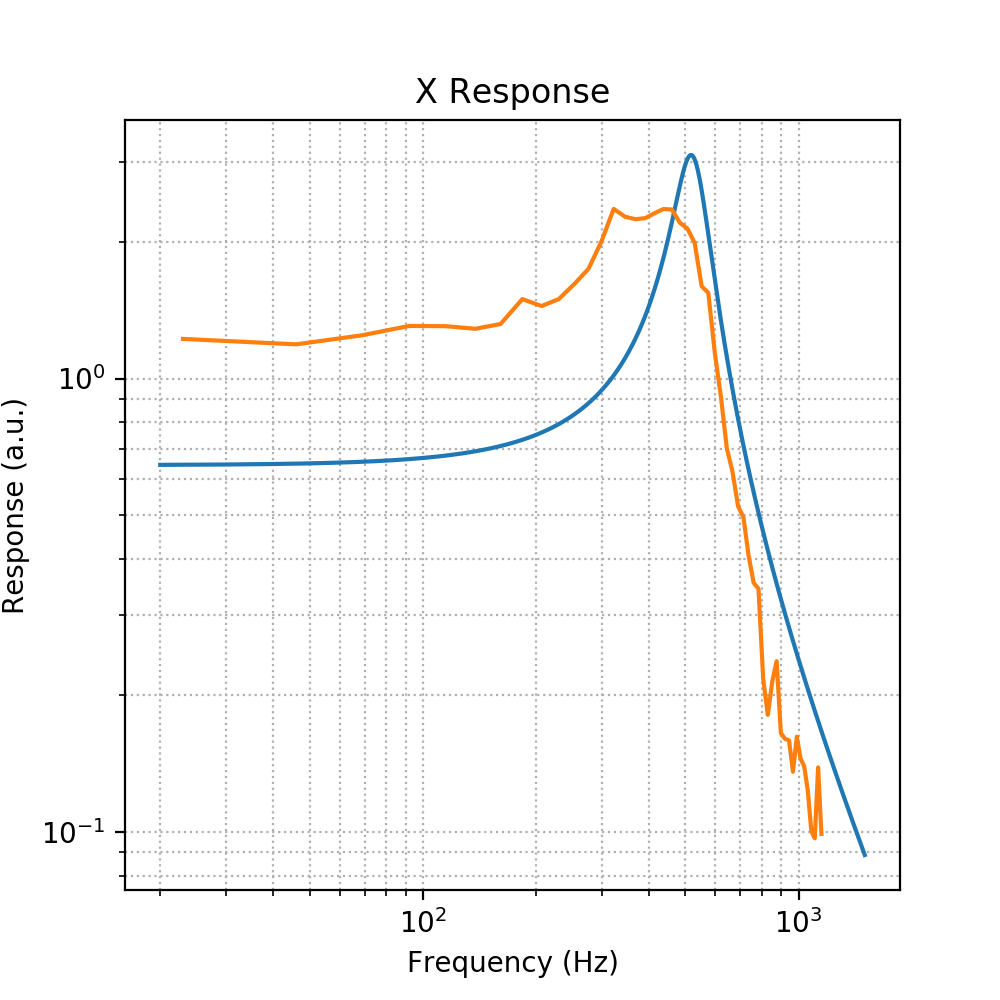

In [513]:
_,ax = plt.subplots(figsize = (5,5))
n = np.linspace(20,1500,2000)

ax.set_ylabel('Response (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('X Response')
ax.loglog(n,Xmodel_x(res,n))
ax.loglog(Xfreq_x,Xfft_x)
ax.grid(b=True,which = 'both', ls = 'dotted')



<IPython.core.display.Javascript object>


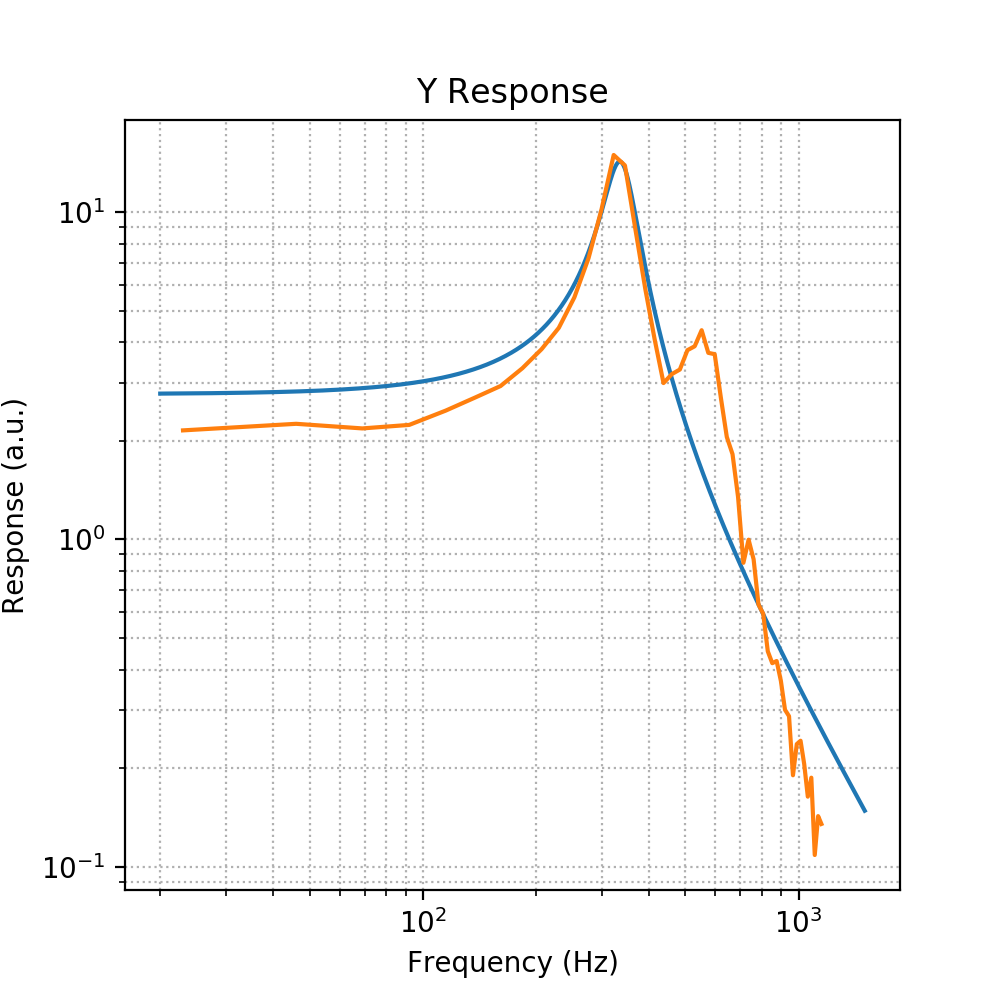

In [514]:
_,ax = plt.subplots(figsize = (5,5))
n = np.linspace(20,1500,2000)

ax.set_ylabel('Response (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Y Response')
ax.loglog(n,Ymodel_y(res,n))
ax.loglog(Yfreq_y,Yfft_y)
ax.grid(b=True,which = 'both', ls = 'dotted')


<IPython.core.display.Javascript object>


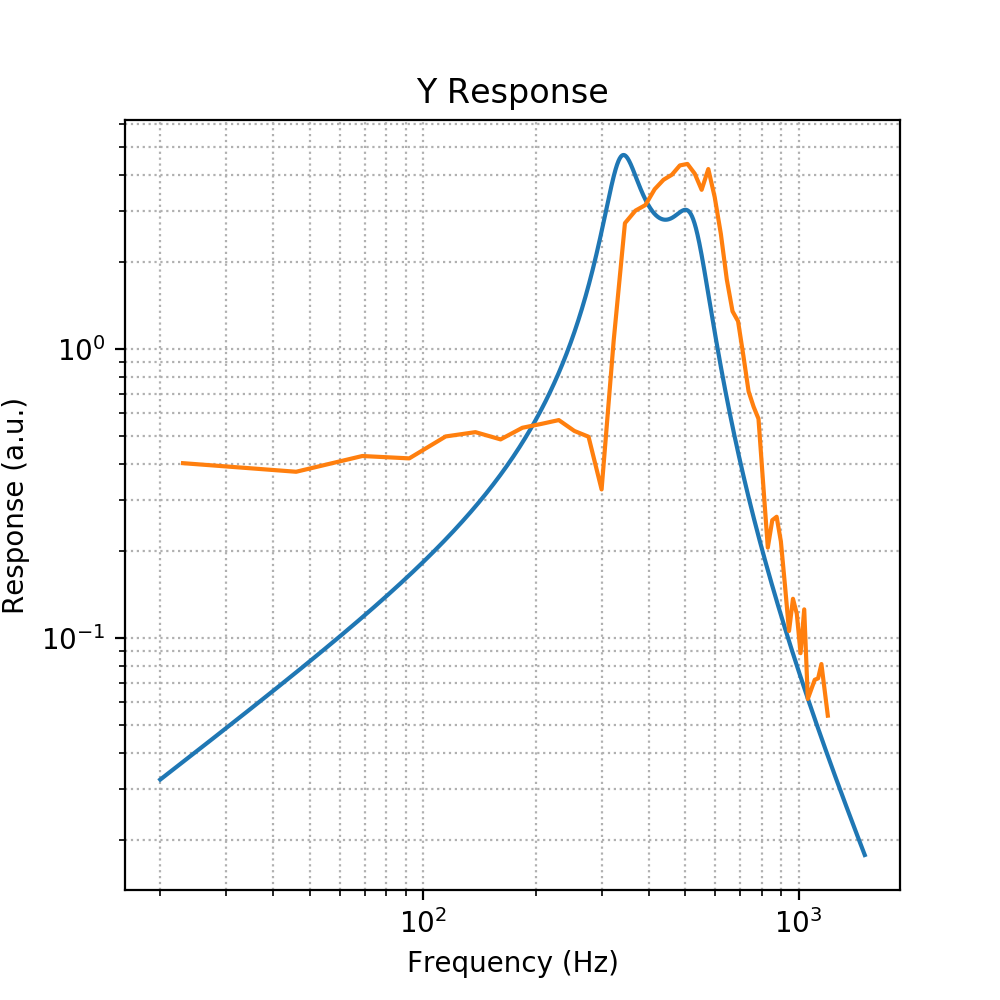

In [515]:
_,ax = plt.subplots(figsize = (5,5))
n = np.linspace(20,1500,2000)

ax.set_ylabel('Response (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Y Response')
ax.loglog(n,Xmodel_y(res,n))
ax.loglog(Xfreq_y,Xfft_y)
ax.grid(b=True,which = 'both', ls = 'dotted')


<IPython.core.display.Javascript object>


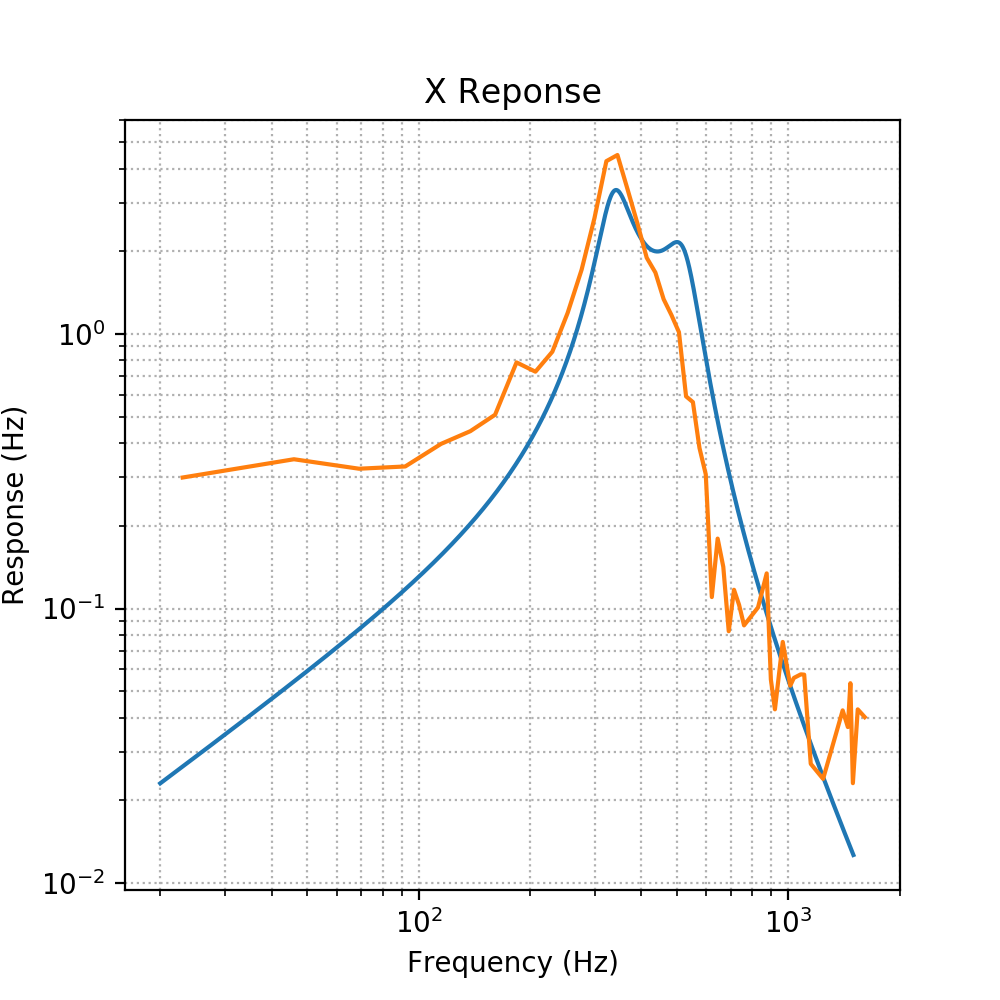

In [516]:
_,ax = plt.subplots(figsize = (5,5))
n = np.linspace(20,1500,2000)

ax.set_ylabel('Response (Hz)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('X Reponse')
ax.loglog(n,Ymodel_x(res,n))
ax.loglog(Yfreq_x,Yfft_x)
ax.grid(b=True,which = 'both', ls = 'dotted')
